#### Processamento de Big Data: Projeto Final

Licenciatura em Ciência de Dados

CDB1

Marco Delgado Esperança, Nº 110451

Maria João Ferreira Lourenço, Nº 104716

Docente: João Oliveira

8 de abril de 2023

Flight Status Prediction

https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022

# Treino e teste e implementação dos modelos

Este notebook contém a criação do treino e teste e a implementação de 2 modelos - um de aprendizagem supervisionada e outro de aprendizagem não superviisionada.

In [1]:
spark

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1680800037789_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
#spark.stop()

In [2]:
filename = "./flights_clean.parquet"
filename_s3 = "s3://pbdmybucketgrupo3/flights_clean.parquet/"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
df_flights_clean = spark.read.format("parquet").load(filename_s3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
df_flights_clean.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- FlightDate: timestamp (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = tru

In [5]:
df_sample = df_flights_clean.sample(False, 0.1, seed=42)
df_sample = df_sample.limit(15000000)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# Some Spark related imports we will use hereafter

import sys
import time

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
import numpy as np

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Aprendizegam supervisionada

## SVM (Classificação)

Para este conjunto de dados, vamos aplicar um modelo de classificação binária por SVM (Support Vector Machine), com o objetivo de prever se um voo chegará com um atraso superior a 15 minutos (**target**: **ArrDel15**). A escolha deste target se deve ao fato de que um atraso superior a 15 minutos pode ter um grande impacto na programação e planejamento dos passageiros e das companhias aéreas, além de poder resultar em custos adicionais para a empresa. Através deste modelo, é possível identificar os principais fatores que contribuem para a ocorrência de atrasos e, consequentemente, ajudar as companhias aéreas a tomar medidas preventivas para reduzir a incidência de atrasos em voos futuros.

<br>
<br>

É uma boa prática separar as variáveis numéricas das variáveis não numéricas, pois o modelo SVM pode não lida bem com variáveis não numéricas diretamente. Portanto, as variáveis não numéricas devem ser transformadas em variáveis numéricas usando técnicas como a codificação one-hot encoding ou a codificação de rótulos (label encoding) antes de serem incluídas no modelo.<br><br>

Desta forma, para iniciar o processo, este código cria duas listas de variáveis independentes, uma lista chamada *cls_numeric* e outra chamada *cls_non_numeric*. A lista *cls_numeric* contém as colunas do dataframe *df_sample* que contêm variáveis numéricas que podem ser utilizadas como recursos no modelo SVM, enquanto a lista *cls_non_numeric* contém as colunas do dataframe *df_sample* que contêm variáveis não numéricas.<br><br>

In [11]:
cls_numeric = ["CRSDepTime", "DepDelayMinutes", "DepDelay", "ArrTime", "ArrDelayMinutes", "AirTime", "CRSElapsedTime",               
               "ActualElapsedTime", "Distance", "Quarter", "DOT_ID_Marketing_Airline", "Flight_Number_Marketing_Airline","OriginAirportID", 
               "OriginAirportSeqID", "DestAirportID", "DestAirportSeqID", "DepartureDelayGroups", "WheelsOff",  "WheelsOn", "ArrDel15", "ArrTimeBlk"]

cls_non_numeric = [i for i in df_flights_clean.columns if i not in cls_numeric]
cls_non_numeric

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted', 'DepTime', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'IATA_Code_Marketing_Airline', 'Operating_Airline', 'IATA_Code_Operating_Airline', 'Tail_Number', 'OriginCityName', 'OriginState', 'OriginStateName', 'DestCityName', 'DestState', 'DestStateName', 'DepDel15', 'DepTimeBlk', 'ArrDelay']

<br>
<br>

A primeira parte do código define as colunas que não são features (*cls_not_features*), ou seja, as colunas que não serão utilizadas como input para o modelo (nomeadamente o target e possíveis preditores multicolineares). Depois, são definidas as colunas categóricas e não categóricas. 

O próximo passo é codificar as colunas categóricas em índices numéricos, que podem ser usados como input para o modelo. Para isso, é usado um objeto designado StringIndexer. Em seguida, é criado um objeto OneHotEncoder que transforma os índices numéricos em vetores binários, que são mais adequados para o modelo.

Por fim, é usado um objeto VectorAssembler para juntar todas as colunas num único vetor, que será o input do modelo de classificação. As colunas de entrada são especificadas como *assembler_inputs*, que contém os nomes das colunas categóricas e não categóricas codificadas e os seus índices numéricos correspondentes. O vetor resultante é atribuído à coluna *features*.

<br>
<br>

In [12]:
# Encoding columns and vector assembling them
# See Chapter 10 of the book "Learning Spark - Lightning-Fast Data Analytics"

cls_not_features = ['FlightDate', 'ArrDelay', 'ArrDel15', 'ArrTimeBlk', "Cancelled", "Diverted"] 
categorical_cols = [i for i in cls_non_numeric if i not in cls_not_features]
non_categorical_cols = [i for i in cls_numeric if i not in cls_not_features]

index_output_cols = [x + ' Index' for x in categorical_cols]
ohe_output_cols = [x + ' OHE' for x in categorical_cols]

string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_output_cols, handleInvalid="skip")

ohe_encoder = OneHotEncoder(inputCols=index_output_cols, outputCols=ohe_output_cols)
   
# Put all input features into a single vector, by using a transformer

assembler_inputs = ohe_output_cols + non_categorical_cols
vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
assembler_inputs

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['Airline OHE', 'Origin OHE', 'Dest OHE', 'DepTime OHE', 'Year OHE', 'Month OHE', 'DayofMonth OHE', 'DayOfWeek OHE', 'Marketing_Airline_Network OHE', 'Operated_or_Branded_Code_Share_Partners OHE', 'IATA_Code_Marketing_Airline OHE', 'Operating_Airline OHE', 'IATA_Code_Operating_Airline OHE', 'Tail_Number OHE', 'OriginCityName OHE', 'OriginState OHE', 'OriginStateName OHE', 'DestCityName OHE', 'DestState OHE', 'DestStateName OHE', 'DepDel15 OHE', 'DepTimeBlk OHE', 'CRSDepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime', 'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance', 'Quarter', 'DOT_ID_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'OriginAirportID', 'OriginAirportSeqID', 'DestAirportID', 'DestAirportSeqID', 'DepartureDelayGroups', 'WheelsOff', 'WheelsOn']

In [13]:
categorical_cols

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['Airline', 'Origin', 'Dest', 'DepTime', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'IATA_Code_Marketing_Airline', 'Operating_Airline', 'IATA_Code_Operating_Airline', 'Tail_Number', 'OriginCityName', 'OriginState', 'OriginStateName', 'DestCityName', 'DestState', 'DestStateName', 'DepDel15', 'DepTimeBlk']

In [14]:
non_categorical_cols

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['CRSDepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime', 'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance', 'Quarter', 'DOT_ID_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'OriginAirportID', 'OriginAirportSeqID', 'DestAirportID', 'DestAirportSeqID', 'DepartureDelayGroups', 'WheelsOff', 'WheelsOn']

<br>
<br>

Este código divide o data set *df_sample* aleatoriamente em dois subconjuntos: um conjunto de treino (*df_train*) e um conjunto de teste (*df_test*).<br>
Usando uma seed de 42, para garantir que subamostra seja sempre a mesma, atribui-se 80% ao conjunto de treino e 20% ao conjunto de teste.

In [15]:
df_train, df_test = df_flights_clean.randomSplit([0.8, 0.2], 42) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<br>

Em seguida apresenta-se a contabilização do número de elementos no conjunto de treino e no conjunto de teste.

In [16]:
print(f"There are {df_train.count()} rows in the training set and {df_test.count()} in the test set.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

There are 22671355 rows in the training set and 5668003 in the test set.

Tal como definido anteriormente, o modelo será treinado com a coluna *ArrDel15* como target e usará o algoritmo de otimização de gradiente descendente para minimizar a função de perda durante o treino.<br>

<br>

Os hiperparâmetros definidos são:

- maxIter: número máximo de iterações permitidas pelo algoritmo de otimização de gradiente descendente (10);
- regParam: parâmetro de regularização para evitar overfitting (ajuste excessivo) do modelo (0.1).

In [17]:
lsvc = LinearSVC(maxIter=10, regParam=0.1, labelCol='ArrDel15')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Seguidamente, criou-se um Pipeline que encapsula todo o processo de transformação e treino do modelo de classificação. O pipeline consiste em uma sequência de estados (stages), que devem ser executados em ordem.

Neste caso, a lista de estados é definida como [string_indexer, ohe_encoder, vec_assembler, lsvc].

- **string_indexer**: um transformador que mapeia colunas categóricas em índices numéricos.
- **ohe_encoder**: um transformador que transforma os índices numéricos em vetores binários (one-hot-encoding).
- **vec_assembler**: um transformador que une todos os vetores de entrada em um único vetor.
- **lsvc**: um estimador de classificação, que neste caso é um LinearSVC.

In [18]:
pipeline = Pipeline(stages=[string_indexer, ohe_encoder, vec_assembler, lsvc])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Assim, criou-se um modelo de pipeline utilizando os dados de treino *df_train*.

In [19]:
start_time = time.time()
pipeline_model = pipeline.fit(df_train)
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time/60
print("Tempo total de execução (s):", elapsed_time, "segundos")
print("Tempo total de execução (min):", elapsed_time_min, "minutos")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Tempo total de execução (s): 2517.111598968506 segundos
Tempo total de execução (min): 41.95185998280843 minutos

<br>

De seguida, aplica-se o modelo treinado (pipeline_model) ao conjunto de dados de teste (*df_test*), usando o método transform() do PipelineModel. O resultado é armazenado em um novo DataFrame chamado *df_prediction*, imprimindo-se a estrutura (schema) do DataFrame resultante.

<br>

In [20]:
# Make predictions on test data and show values of columns of interest

df_prediction = pipeline_model.transform(df_test)

# Check its schema

df_prediction.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- FlightDate: timestamp (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = tru

Este código mostra as colunas 'features', 'rawPrediction', 'prediction' e 'ArrDel15' do DataFrame df_prediction.

- A coluna **features** representa as características do voo (horários de partida e chegada, duração, etc.) em formato vetor. Essas características foram criadas anteriormente através do processo de codificação e vetorização.

- A coluna **rawPrediction** mostra a pontuação resultante da aplicação do modelo LinearSVC às características do voo. Essa pontuação não é a previsão final (0 ou 1), mas é uma medida da confiança do modelo na previsão.

- A coluna **prediction** mostra a previsão final (0 ou 1) do modelo LinearSVC para a coluna 'ArrDel15' (o atraso na chegada é maior ou igual a 15 minutos).

- A coluna **ArrDel15** é a variável alvo que indica se o voo teve um atraso na chegada maior ou igual a 15 minutos (1) ou não (0).

In [22]:
# Columns to be focus on

df_prediction.select('features', 'rawPrediction', 'prediction', 'ArrDel15').show() 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+----------+--------+
|            features|       rawPrediction|prediction|ArrDel15|
+--------------------+--------------------+----------+--------+
|(10432,[17,155,41...|[1.39313071054016...|       0.0|     0.0|
|(10432,[17,137,43...|[1.41512528286250...|       0.0|     0.0|
|(10432,[17,137,41...|[1.34348518553140...|       0.0|     0.0|
|(10432,[17,156,41...|[-1.2376211872544...|       1.0|     1.0|
|(10432,[17,235,41...|[-16.656822755775...|       1.0|     1.0|
|(10432,[17,116,41...|[1.36104497631456...|       0.0|     0.0|
|(10432,[17,171,41...|[1.41092836803438...|       0.0|     0.0|
|(10432,[17,112,41...|[1.38363329294186...|       0.0|     0.0|
|(10432,[17,50,460...|[1.37251042506783...|       0.0|     0.0|
|(10432,[17,50,503...|[1.41651755657751...|       0.0|     0.0|
|(10432,[17,50,503...|[1.38350924377027...|       0.0|     0.0|
|(10432,[17,50,522...|[1.35101385206167...|       0.0|     0.0|
|(10432,[17,50,480...|[-5.3688439742948.

### Avaliação dos resultados

Em primeiro lugar, procedeu-se ao cálculo da métrica de avaliação binária "areaUnderROC" (Área sob a curva ROC), que é uma medida da qualidade do modelo para classificar corretamente exemplos positivos e negativos. Para isso, são usados os dados de teste que foram processados pelo pipeline de treinamento e ajustados pelo modelo treinado.

In [23]:
# Compute evaluation metrics on test data

prediction_label = df_prediction.select('rawPrediction', 'prediction', 'ArrDel15')  

# supports metricName="areaUnderROC" (default) and "areaUnderPR"
# it relates to sensitivity (TP rate) and specificity (FP rate)

evaluator = BinaryClassificationEvaluator(labelCol='ArrDel15')

print("areaUnderROC = " + str(evaluator.evaluate(prediction_label)))
# print("areaUnderPR = " + str(evaluator.evaluate(prediction_label, {evaluator.metricName: 'areaUnderPR'})))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

areaUnderROC = 0.9657404665493518

No contexto deste modelo, uma área sob a curva ROC de 0.9778 indica que o modelo é capaz de distinguir entre voos que chegam com atraso de pelo menos 15 minutos e voos que chegam na hora ou com um atraso menor com uma precisão muito alta.

<br>

Em seguida, para o cálculo de diversas métricas de classificação, procedeu-se ao cálculo da contagem de cada caso do resultado da previsão feita pelo modelo SVM no conjunto de teste. 

In [24]:
# Counting rows for each case TP, TN, FP and FN respectively

n = df_prediction.count()
tp = df_prediction.filter((F.col('prediction') > 0) & (F.col('ArrDel15') == 1)).count()
tn = df_prediction.filter((F.col('prediction') == 0) & (F.col('ArrDel15') == 0)).count()
fp = df_prediction.filter((F.col('prediction') > 0) & (F.col('ArrDel15') == 0)).count()
fn = n - tp - tn - fp
[tp, tn, fp, fn, n]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[640001, 4649534, 16635, 361832, 5668002]

In [25]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.9332274406395763

No contexto deste modelo, uma accuracy de 0.933 significa que o modelo acertou 93.3% das vezes na sua previsão de atrasos de voo de pelo menos 15 minutos.

In [27]:
precision = tp / (tp + fp)
precision

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.9746663295950877

A precision de 0.975 significa que, das vezes em que o modelo previu que um voo seria atrasado em pelo menos 15 minutos (ou seja, classificou como positivo), em média, 97.5% desses voos realmente foram atrasados.

In [28]:
recall = tp / (tp + fn)
recall

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.6388300245649724

Um recall de 0.639 significa que o modelo foi capaz de identificar corretamente 63.9% de todos os voos que realmente atrasaram pelo menos 15 minutos (classe positiva).

In [29]:
specificity = tn / (tn + fp)
specificity

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.9964349769586143

No contexto do modelo, uma specificity de 0.996 significa que 99.6% dos voos que não tiveram atrasos superiores a 15 minutos foram corretamente identificados como não tendo atrasos significativos pelo modelo.

In [30]:
f1_score = 2 * recall * precision / (recall + precision)
f1_score

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.7717973625072281

No que diz respeito ao F1-score, que é de 0.771, significa que o modelo é razoavelmente preciso na detecção de voos atrasados pelo menos 15 minutos (classe positiva) e não atrasados (classe negativa). 

# Aprendizagem não supervisionada 

## KMeans

No contexto de dados de atrasos em voos, o modelo KMeans, um dos algoritmos mais populares de aprendizagem não supervisionada, pode ser usado como uma ferramenta de aprendizagem não supervisionada para descobrir padrões e agrupamentos entre os voos com atrasos. Esses padrões podem ajudar as companhias aéreas e os reguladores a entender melhor as causas dos atrasos e a tomar medidas para melhorar o desempenho e a eficiência do sistema de transporte aéreo. O modelo KMeans é especialmente adequado para esse tipo de análise, pois é capaz de agrupar dados em clusters com base nas suas características semelhantes, o que pode ser útil para detectar padrões ocultos e relacionamentos entre os voos com atrasos.

In [8]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<br>

### Padrões de atraso entre atrasos de partida/chegada e distância

Em primeiro lugar, procedeu-se à seleção de três colunas específicas (*DepDelay*, *ArrDelay* e *Distance*) do DataFrame *df_sample*. As colunas selecionadas são usadas para ajustar um modelo de clustering K-means.

In [9]:
cols = ["DepDelay", "ArrDelay", "Distance"]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

De seguida, criou-se uma instância do VectorAssembler, que é um transformador que combina várias colunas em uma única coluna de recursos (features).
Recorreu-se ao método "transform()" do VectorAssembler para aplicar a transformação aos dados em *df_sample*. O parâmetro *inputCols* especifica as colunas de entrada que serão usadas para criar a nova coluna de recursos (features), enquanto o parâmetro *outputCol* especifica o nome da nova coluna criada.

In [10]:
# Criação do vector

vec_assembler = VectorAssembler(inputCols=cols, outputCol="features")
vec_df = vec_assembler.transform(df_flights_clean)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
# Imprimir as colunas do vetor

vec_df.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted', 'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime', 'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'Operating_Airline', 'IATA_Code_Operating_Airline', 'Tail_Number', 'OriginAirportID', 'OriginAirportSeqID', 'OriginCityName', 'OriginState', 'OriginStateName', 'DestAirportID', 'DestAirportSeqID', 'DestCityName', 'DestState', 'DestStateName', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'WheelsOff', 'WheelsOn', 'ArrDelay', 'ArrDel15', 'ArrTimeBlk', 'features']

<br>

De forma a escolhermos o melhor k (número de clusters) para a aplicação do algoritmo KMeans, decidimos reduzir o tamanho do vetor usado para treinar o modelo, limitando o número de linhas do DataFrame da amostra para 100 (*max_tiny*). <br>

Definido esse limite, após a criação do DataFrame *vec_dftiny* limitado com o número de linhas anteriormente indicado, aplicou-se o VectorAssembler que combina as colunas especificadas em *cols* em uma única coluna de features, que é adicionada como uma nova coluna no DataFrame resultante.

In [12]:
# para encontrar o melhor k iremos reduzir o tamanho do nosso vetor
max_tiny = 100
vec_dftiny = vec_assembler.transform(df_flights_clean.limit(max_tiny))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<br>

Criou-se uma instância do modelo K-means com o número de clusters definido por "k", semente (seed) igual a 221 e número máximo de iterações igual a 20.
Ajustou-se o modelo aos dados de treino (*vec_dftiny*) usando o método "fit()", sendo o modelo é usado para gerar previsões para os dados de treino usando o método "transform()".<br>
Os centroids são armazenados numa lista designada *cluster_centres*.
Por fim, calcula-se a métrica de Silhouette para as previsões geradas pelo modelo, usando o objeto *evaluator*, sendo o valor armazenado na lista *silhouettes*.
 código fornece uma lista de valores de Silhouette para cada valor de "k" testado. Isso pode ser usado para selecionar o número ideal de clusters para o modelo de KMeans. O número ideal de clusters é aquele que maximiza a métrica de Silhouette.

In [13]:
# Algortimo K-Means
from pyspark.ml.evaluation import ClusteringEvaluator

start_time = time.time()
evaluator = ClusteringEvaluator()

silhouettes = []
cluster_centres = []
for k in range(2,20):
    
    # Treina um modelo K-mean
    kmeans = KMeans(k=k, seed=221, maxIter=20)
    
    # Ajuste do modelo
    model = kmeans.fit(vec_dftiny)
    
    # usar modelo para transformar o DataFrame ao adicionar previsões com aglomerados ("cluster") 
    predictions = model.transform(vec_dftiny)
    

    # Obter ClustersCenters através do modelo
    cluster_centres.append(model.clusterCenters())
    
    # Avaliação do modelo com base no silhouette
    silhouettes.append(evaluator.evaluate(predictions))

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time/60
print("Tempo total de execução (s):", elapsed_time, "segundos")
print("Tempo total de execução (min):", elapsed_time_min, "minutos")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Tempo total de execução (s): 74.67615747451782 segundos
Tempo total de execução (min): 1.244602624575297 minutos

De seguida, imprime-se os resultados dos centroides dos clusters e das métricas de Silhouette para cada valor de k testado no modelo de clustering KMeans.

In [14]:
# Resultados dos clusterscenters e silhouette

print("Cluster centres: ")
for centroid in cluster_centres:
    print(centroid)
print("Silhouettes with squared euclidean distances: ")
print(silhouettes)
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time/60
print("Tempo total de execução (s):", elapsed_time, "segundos")
print("Tempo total de execução (min):", elapsed_time_min, "minutos")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Cluster centres: 
[array([8.17741935e+00, 1.45161290e-01, 1.96870968e+02]), array([ 16.89473684,   8.81578947, 574.05263158])]
[array([ 10.75      ,  -3.54166667, 545.95833333]), array([  2.61904762,  -2.92857143, 158.16666667]), array([ 16.41176471,  10.76470588, 371.61764706])]
[array([ -0.98245614,  -9.77192982, 196.        ]), array([ 19.32352941,  11.41176471, 546.05882353]), array([ -3.75, -13.25, 812.  ]), array([112.6, 113.2, 206.8])]
[array([ 13.90909091,   3.18181818, 505.48484848]), array([ -2.775,  -8.9  , 158.825]), array([110.5, 116.5, 145. ]), array([ 91.,  88., 752.]), array([ 11.08333333,   3.66666667, 346.04166667])]
[array([ 46.07692308,  42.38461538, 413.84615385]), array([ -2.775,  -8.9  , 158.825]), array([110.5, 116.5, 145. ]), array([ 91.,  88., 752.]), array([ -1.95238095,  -8.80952381, 345.47619048]), array([  7.26086957,  -7.52173913, 537.        ])]
[array([  1.20689655, -10.44827586, 240.10344828]), array([148.2, 153.4, 486.2]), array([ -3.75, -13.25, 812. 

<br>

Em seguida, procurou-se o k que maximiza a Silhouette score.

In [15]:
optimal_k = np.argmax(silhouettes[2:20]) + 2
optimal_k

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

11

O pico mais alto é atingido para k=11, então escolhe-se esse valor para k.

<br>

Aplica-se o modelo KMeans, usando o valor ótimo determinado para k (5).
O modelo KKMeans é inicializado com o número de clusters ótimo encontrado anteriormente (*optimal_k*=5), um valor de semente aleatório fixo (*seed*=221) e um limite máximo de iterações (*maxIter*=20).<br>
Ajusta-se  o modelo aos dados de treino usando o método "fit()" com o conjunto de dados que passou pelo processo de transformação com VectorAssembler (*vec_df*).<br> 
O modelo é então usado para prever os clusters para todo o conjunto de dados com o método "transform()".<br>
Usa-se o método "clusterCenters()" para obter os centroides dos clusters do modelo, usando a métrica de Silhouette para avaliar o desempenho do modelo.<br>
Finalmente, imprimem-se os centroides dos clusters.

<br>

In [16]:
# Avaliar o modelo com optimal_k = 11

# Algoritmo K-means aplicado a todo o dataset (sem vec_dftiny)
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

start_time = time.time()
# Loads data
dataset = df_flights_clean

# Treina um modelo K-mean
kmeans = KMeans(k=optimal_k, seed=221, maxIter=20)

# Ajuste do modelo
model = kmeans.fit(vec_df)

# usar modelo para transformar o DataFrame ao adicionar previsões com aglomerados ("cluster") 
predictions = model.transform(vec_df)
    
# Obter ClustersCenters através do modelo
cluster_centres = model.clusterCenters()

# Avaliar o clustering calculando o valor do Silhouette
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Mostrar os resultados
print("Cluster Centers: ")
ctr=[]
centers = model.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)
    
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time/60
print("Tempo total de execução (s):", elapsed_time, "segundos")
print("Tempo total de execução (min):", elapsed_time_min, "minutos")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Silhouette with squared euclidean distance = 0.6530132618837142
Cluster Centers: 
[  6.84623135   1.76972071 392.33006143]
[9.38637289e+00 7.47110888e-01 2.48294127e+03]
[623.53601671 621.29480674 592.78651025]
[1.09767524e+01 6.95208518e-01 4.84482431e+03]
[  8.55899613   2.77950064 874.78521601]
[  6.42340232   1.9872594  196.29920608]
[9.84712080e+00 1.55376608e+00 1.98940140e+03]
[   9.53341133    2.15854312 1542.8296125 ]
[   9.8375297     3.85744608 1127.37399453]
[1.03688719e+01 1.02580510e+00 3.69896260e+03]
[  7.50592341   2.17825291 616.14060382]
Tempo total de execução (s): 167.2504825592041 segundos
Tempo total de execução (min): 2.7875080426534016 minutos

Com todas as variaveis e K=11, Silhouette with squared euclidean distance = 0.6538, logo o modelo tem uma coesão moderada com os dados iniciais.

<br>

De seguida, apresenta-se o número dos diferentes clusters.

In [17]:
# Mostrar os números dos diferentes clusteres

predictions.select("prediction").distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+
|prediction|
+----------+
|         1|
|         6|
|         3|
|         4|
|         8|
|         5|
|         2|
|         7|
|         0|
|         9|
|        10|
+----------+

Vamos então guardar o modelo para se posteriormente o quisermos usar, nomeadamente para efeitos de visualização.

In [46]:
model.save("kmeans_model_1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
path_save = "s3://pbdmybucketgrupo3/modelos"
model.save(path_save)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
from pyspark.ml.clustering import KMeansModel
kmeans_model = KMeansModel.load("kmeans_model_1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Gráfico de dispersão para a relação entre o atrasado de partida (DepDelay) e o atraso de chegada (ArrDelay)

/var/folders/6f/xxdlxkl953v7h6b6nsn7dhp40000gn/T/ipykernel_21615/3442062530.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_plot.iloc[:,0], df_plot.iloc[:,1], s=40, cmap='viridis');


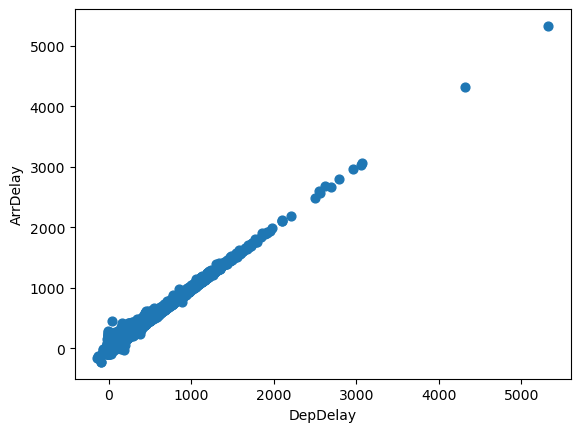

In [57]:
# Vizualização do algoritmo K Means
import matplotlib.pyplot as plt 
import pandas
import numpy as np

df_plot =  predictions.select(["DepDelay", "ArrDelay", "Distance"]).toPandas()
plt.xlabel('DepDelay')
plt.ylabel('ArrDelay')
plt.scatter(df_plot.iloc[:,0], df_plot.iloc[:,1], s=40, cmap='viridis');

Verifica-se que há uma relação, tal como se esperava, diretamente proporcinal entre o atrado de partida (*DepDelay*) e atraso de chegada (*ArrDelay*).

## Gráfico de dispersão para a relação entre o atraso na partida (DepDelay) e a distância entre os aeroportos (Distance)

/var/folders/6f/xxdlxkl953v7h6b6nsn7dhp40000gn/T/ipykernel_21615/1811034646.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_plot.iloc[:,0], df_plot.iloc[:,2], s=20, cmap='viridis');


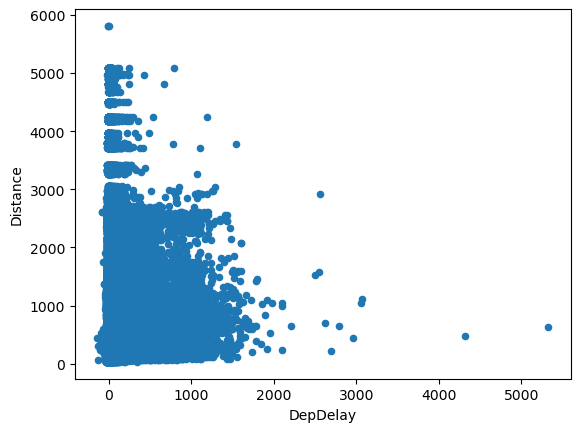

In [58]:
df_plot =  predictions.select(["DepDelay", "ArrDelay", "Distance"]).toPandas()
plt.xlabel('DepDelay')
plt.ylabel('Distance')
plt.scatter(df_plot.iloc[:,0], df_plot.iloc[:,2], s=20, cmap='viridis');

Neste gráfico podemos observar que há uma tendência para quanto maior for a distância da viagem, menor costumam ser os atrasos nas partidas. Além disso, verifica-se que a maioria dos atrasos não é muito significativo, até porque a viagem mais longa tem um atraso nulo.

## Gráfico de dispersão para a relação entre o atraso de chegada (ArrDelay) e a distância entre aeroportos (Distance)

/var/folders/6f/xxdlxkl953v7h6b6nsn7dhp40000gn/T/ipykernel_21615/3671868252.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_plot.iloc[:,1], df_plot.iloc[:,2], s=20, cmap='viridis');


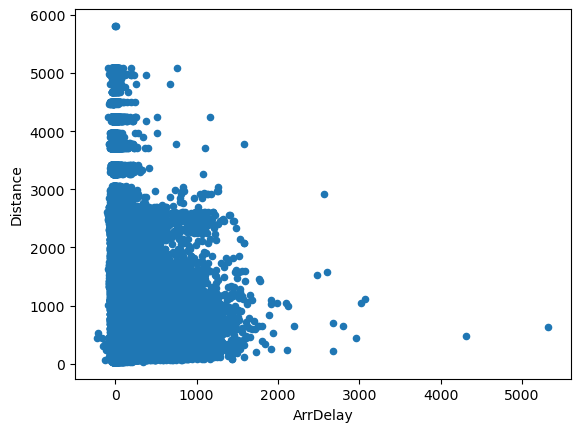

In [52]:
df_plot =  predictions.select(["DepDelay", "ArrDelay", "Distance"]).toPandas()
plt.xlabel('ArrDelay')
plt.ylabel('Distance')
plt.scatter(df_plot.iloc[:,1], df_plot.iloc[:,2], s=20, cmap='viridis');

De forma idêntica à análise anterior, verifica-se que há uma tendência para quanto maior for a distância na viagem, menor costumam ser os atrasos nas chegadas.

## Identificar padrões de atraso baseado em outros fatores

De forma a identificar padrões de atraso baseados em outros fatores escolheram-se as colunas que se apresentam abaixo para aplicar o KMeans.

In [9]:
cols2 = ["Airline", "Origin", "Dest", "CRSDepTime", "DepDelayMinutes", "DepDelay", "ArrDelayMinutes", "AirTime", "Distance", "Month"]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<br>

Primeiro, são criados indexadores de string para as colunas "Airline", "Origin" e "Dest". O resultado desse processo é uma nova coluna para cada coluna original, com o sufixo "_index", contendo os valores numéricos correspondentes a cada categoria.

Em seguida, é utilizado o encoder OneHotEncoder para converter as colunas indexadas em vetores binários, onde cada elemento do vetor representa uma categoria da variável. Assim, para cada categoria, é criado um novo atributo, onde o valor 1 indica que aquela categoria está presente na observação e o valor 0 indica ausência.

As colunas selecionadas para compor o vetor de características são: "CRSDepTime", "DepDelayMinutes", "DepDelay", "ArrDelayMinutes", "AirTime", "Distance", "Month", "Airline_vec", "Origin_vec" e "Dest_vec". É utilizado o VectorAssembler para juntar essas colunas em um único vetor, com o nome "features", que será utilizado no treinoo do modelo. O método "limit(100)" é utilizado para limitar o número de observações do dataset para 100, apenas para fins de demonstração.

<br>

In [10]:
# Criação do vector
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep")
            for col in ["Airline", "Origin", "Dest"]]
indexed = Pipeline(stages=indexers).fit(df_flights_clean).transform(df_flights_clean)


encoder = OneHotEncoder(inputCols=["Airline_index", "Origin_index", "Dest_index"], outputCols=["Airline_vec", "Origin_vec", "Dest_vec"])
encoded = encoder.fit(indexed).transform(indexed)


cols2 = ["CRSDepTime", "DepDelayMinutes", "DepDelay", "ArrDelayMinutes", "AirTime", "Distance", "Month", "Airline_vec", "Origin_vec", "Dest_vec"]
assembler = VectorAssembler(inputCols=cols2, outputCol="features")
assembled = assembler.transform(encoded.limit(100))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

De forma análoga à explicada anteriormente, calcula-se o Silhouette score para diferentes valores de k.

In [11]:
# Algortimo K-Means
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

start_time = time.time()
evaluator = ClusteringEvaluator()

silhouettes = []
cluster_centres = []
for k in range(2,20):
    
    # Treina um modelo K-mean
    kmeans = KMeans(k=k, seed=221, maxIter=20)
    
    # Ajuste do modelo
    model = kmeans.fit(assembled)
    
    # usar modelo para transformar o DataFrame ao adicionar previsões com aglomerados ("cluster") 
    prediction = model.transform(assembled)
    

    # Obter ClustersCenters através do modelo
    cluster_centres.append(model.clusterCenters())
    
    # Avaliação do modelo com base no silhouette
    silhouettes.append(evaluator.evaluate(prediction))
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time/60
print("Tempo total de execução (s):", elapsed_time, "segundos")
print("Tempo total de execução (min):", elapsed_time_min, "minutos")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Tempo total de execução (s): 84.10168242454529 segundos
Tempo total de execução (min): 1.4016947070757548 minutos

<br>

Em seguida, procurou-se o k que maximiza a Silhouette score.

In [12]:
optimal_k = np.argmax(silhouettes[2:20]) + 2
optimal_k

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3

Escolhe-se o valor ótimo segundo a Silhouette score para k (k=3).

Em seguida avalia-se o modelo com k=3 e calcula-se o centroide para cada cluster.

In [13]:
#Avaliar o modelo com optimal_k = 2

# Algoritmo K-means aplicado a todo o dataset (sem vec_dftiny)
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

start_time = time.time()
# Loads data
dataset = df_flights_clean

# Treina um modelo K-mean
kmeans = KMeans(k=optimal_k, seed=221, maxIter=20)

# Ajuste do modelo
model = kmeans.fit(assembled)

# usar modelo para transformar o DataFrame ao adicionar previsões com aglomerados ("cluster") 
predictions = model.transform(assembled)
    
# Obter ClustersCenters através do modelo
cluster_centres = model.clusterCenters()

# Avaliar o clustering calculando o valor do Silhouette
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Mostrar os resultados
print("Cluster Centers: ")
ctr=[]
centers = model.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time/60
print("Tempo total de execução (s):", elapsed_time, "segundos")
print("Tempo total de execução (min):", elapsed_time_min, "minutos")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Silhouette with squared euclidean distance = 0.778477020402866
Cluster Centers: 
[1.22588235e+03 1.84411765e+01 1.61764706e+01 1.52352941e+01
 8.26470588e+01 5.12735294e+02 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.94117647e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

- Com todas as variaveis e K=3, Silhouette with squared euclidean distance = 0.778, logo o modelo tem uma coesão forte com os dados iniciais.

<br>

<br>

Seguidamente, apresentam-se o número dos diferentes clusters.

In [14]:
# Mostrar os números dos diferentes clusteres
predictions.select("prediction").distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+
|prediction|
+----------+
|         1|
|         2|
|         0|
+----------+

Em seguida, vamos guardar o modelo para se quisermos posteriormente o usar.

In [15]:
model.save("kmeans_model_2")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
path_save = "s3://pbdmybucketgrupo3/modelos2"
model.save(path_save)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
from pyspark.ml.clustering import KMeansModel
kmeans_model=KMeansModel.load("kmeans_model_2")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# Relembrar as colunas selecionadas

cols2 = ["Airline", "Origin", "Dest", "CRSDepTime", "DepDelayMinutes", "DepDelay", "ArrDelayMinutes", "AirTime", "Distance", "Month"]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Gráfico de dispersão para a relação entre a Origem (Origin) e atraso na partida (DestDelay)

/var/folders/6f/xxdlxkl953v7h6b6nsn7dhp40000gn/T/ipykernel_21615/2158272528.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_plot.iloc[:,1], df_plot.iloc[:,5], s=40, cmap='viridis');


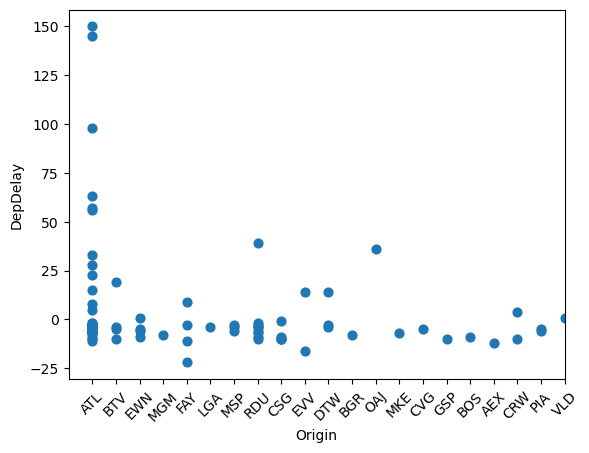

In [69]:
# Visualização do algoritmo Kmeans

df_plot =  predictions.select(cols2).toPandas()
plt.xlim(-1,20)
plt.xticks(rotation=45)
plt.xlabel(cols2[1])
plt.ylabel(cols2[5])
plt.scatter(df_plot.iloc[:,1], df_plot.iloc[:,5], s=40, cmap='viridis');

Pela análise deste gráfico, verificamos que existe um claro destaque com partidas atrasadas para o aeroporto de Atlanta (ATL).

## Gráfico de dispersão para a relação entre o Destino (Dest) e atraso na partida (DestDelay)

/var/folders/6f/xxdlxkl953v7h6b6nsn7dhp40000gn/T/ipykernel_21615/3408388266.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_plot.iloc[:,2], df_plot.iloc[:,5], s=40, cmap='viridis');


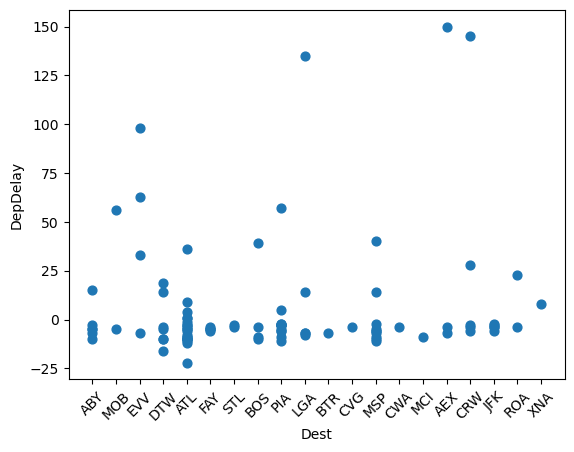

In [79]:
# # Visualização do algoritmo Kmeans

df_plot =  predictions.select(cols2).toPandas()
plt.xlim(-1,20)
plt.xticks(rotation=45)
plt.xlabel(cols2[2])
plt.ylabel(cols2[5])
plt.scatter(df_plot.iloc[:,2], df_plot.iloc[:,5], s=40, cmap='viridis');

Há uma tendência para os voos partirem a tempo ou até adiantados, havendo contudo alguns exemplos de voos com grande atrasos de partida.

## Gráfico de dispersão para a relação entre a origem (Origin) e o atraso de chegada em minutos (ArrDelayMinutes)

/var/folders/6f/xxdlxkl953v7h6b6nsn7dhp40000gn/T/ipykernel_21615/2496826933.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_plot.iloc[:,1], df_plot.iloc[:,6], s=40, cmap='viridis');


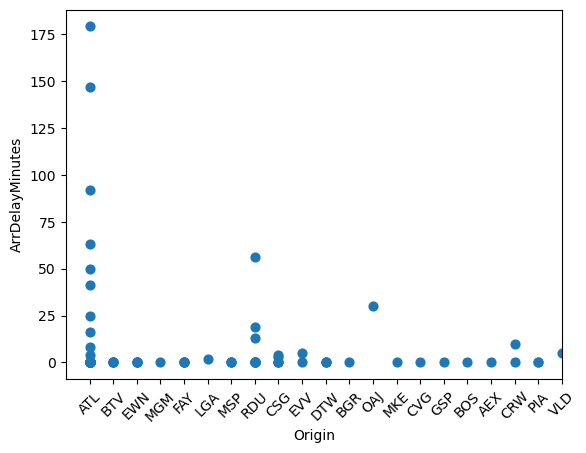

In [72]:
# Visualização do algoritmo Kmeans

df_plot =  predictions.select(cols2).toPandas()
plt.xlim(-1,20)
plt.xticks(rotation=45)
plt.xlabel(cols2[1])
plt.ylabel(cols2[6])
plt.scatter(df_plot.iloc[:,1], df_plot.iloc[:,6], s=40, cmap='viridis');

Constata-se que tal como nos atrasos das partidas, é o aeroporto de Atlanta (ATL) que regista os maiores atrasos de chegada (em minutos).